Copyright 2020 Kim Ward, All Rights Reserved

# A basic Python implementation of FOCuS

FOCuS stores the statistical evidence for a change in $\mu$ beginning at each timestep $\tau$ and (so far) ending at the current time $T$ as a quadratic $q_\tau$. $q_\tau$ passes through the origin, and is fully described by $a_\tau\mu^2+b_\tau\mu$ for $a_\tau$ a negative integer (the time offset $\tau-T-1$) and $b_\tau$ a real number (the sum $\sum_{t=\tau}^{T}2X_t$). When $q_\tau$ is completely dominated by other quadratics, it can be pruned out from the algorithm as we know that any change beginning at time $\tau$ with enough evidence to trigger a detection would mean a change at some other time $\tau^*$ would trigger a detection with a greater significance.

For the purposes of only looking for positive changes ($\mu > 0$), we store the quadratics in a list ordered by their $a$-values in ascending (decreasingly negative) order. This is because quadratics can only ever be pruned out by their left neighbour in this list (you can check the maths works). We only need to iterate through the list once at each time step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

class Quadratic:
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def __repr__(self):
        return f'Quadratic: {self.a}x^2+{self.b}x'
    
    def __sub__(self, other_quadratic):
        #subtraction: needed for quadratic differences
        return Quadratic(self.a-other_quadratic.a, self.b-other_quadratic.b)
    
    def __add__(self, other_quadratic):
        #addition: needed for quadratic differences
        return Quadratic(self.a+other_quadratic.a, self.b+other_quadratic.b)
    
    def evaluate(self, mu):
        return np.maximum(self.a*mu**2 + self.b*mu, 0)
    
    def update(self, X_T):
        return Quadratic(self.a - 1, self.b + 2*X_T)
    
    def ymax(self):
        return -self.b**2/(4*self.a) 
    
    def xmax(self):
        if (self.a==0)and(self.b==0):
            return 0
        else:
            return -self.b/(2*self.a)
    
    def dominates(self, other_quadratic):
        return (self.b>other_quadratic.b)and(self.xmax()>other_quadratic.xmax())

Our algorithm operates on this list of quadratics. At each timestep, it starts from the left (earliest $\tau$ still under consideration) and updates the quadratics sequentially, checking as it goes whether any need pruning and calculating the global maximum. When it reaches the end of the list, it adds a new quadratic for a change beginning at $T$ if the point $X_T$ is big enough to need one.

In [2]:
def focus_step(quadratic_diffs_list, final_quadratic, m_list, X_T):
    
    pruning_done=False
    
    #Updating step
    if final_quadratic.xmax() < X_T:
        #create a new final quadratic
        new_final_quad = Quadratic(-1, 2*X_T)
        new_quad_difference = final_quad - new_final_quad
        quadratic_diffs_list.append(new_quad_difference)
        m_list.append(m_list[-1]+new_quad_difference.ymax())
        final_quadratic = new_final_quad
        pruning_done=True
    else:
        #update final quadratic
        final_quadratic = final_quadratic.update(X_T)
    
    #Pruning step
    
    while not pruning_done:
        second_last_quadratic = final_quadratic + quadratic_diffs_list[-1]
        
        if second_last_quadratic.dominates(final_quadratic):
            #prune out final quadratic
            quadratic_diffs_list.pop()
            m_list.pop()
            final_quadratic = second_last_quadratic
        else:
            pruning_done=True
    
    #Maxima checking step
    


def focus_step(quadratic_list, X_T):
    new_quadratic_list = []
    global_max = 0
    time_offset = 0
    
    if not quadratic_list: #list is empty
        
        if X_T <= 0:
            return new_quadratic_list, global_max, time_offset
        else:
            updated_q = Quadratic(-1, 2*X_T)
            new_quadratic_list.append(updated_q)
            global_max = updated_q.ymax()
            time_offset = updated_q.a
            
    else: #list not empty: go through and prune
        
        updated_q = quadratic_list[0].update(X_T) #check leftmost quadratic separately
        if updated_q.b < 0: #our leftmost quadratic is negative i.e. we have no quadratics
            return new_quadratic_list, global_max, time_offset
        else:
            new_quadratic_list.append(updated_q)
            if updated_q.ymax() > global_max:   #we have a new candidate for global maximum
                global_max = updated_q.ymax()
                time_offset = updated_q.a

            for q in quadratic_list[1:]+[Quadratic(0, 0)]:#add on new quadratic to end of list
                updated_q = q.update(X_T)

                if new_quadratic_list[-1].dominates(updated_q):
                    break #quadratic q and all quadratics to the right of it are pruned out by q's left neighbour
                else:
                    new_quadratic_list.append(updated_q)

                    if updated_q.ymax() > global_max:   #we have a new candidate for global maximum
                        global_max = updated_q.ymax()
                        time_offset = updated_q.a
        
    return new_quadratic_list, global_max, time_offset

In [3]:
focus_step([], 4)

([Quadratic: -1x^2+8x], 16.0, -1)

The outer loop of the algorithm then only needs to check if the calculated maximum is over the threshold. Because the time offset $\tau-T-1$ is stored, we can recover $\tau$ the beginning of the significant change. I've included a plotting function here too.

In [6]:
def plot_quadratics(quadratic_list, threshold, T):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS step")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{T}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0, 5, 100) #the x-axis for the plot
    
    for q in quadratic_list:
        ax.plot(mu, q.evaluate(mu), label=f'$\\tau={q.a+T+1}$')
    
    ax.axhline(0, color='C0')

    if quadratic_list:
        ax.legend()
    return fig

def focus(X, threshold, plot=False):
    quadratic_list = []
    
    for T in range(len(X)):
        quadratic_list, global_max, time_offset = focus_step(quadratic_list, X[T])
        
        if plot:
            clear_output(wait=True)
            plot_quadratics(quadratic_list, threshold, T)
            plt.show()
        
        if global_max > threshold:
            return global_max, time_offset+T+1, T
        
    return 0, len(X)+1, len(X) #no change found by end of signal

### Test case

Here's FOCuS running on a randomly generated signal of 50 normal points then a change to $\mu=1$ for the next 50 points, with the detection threshold of $5\sigma$.

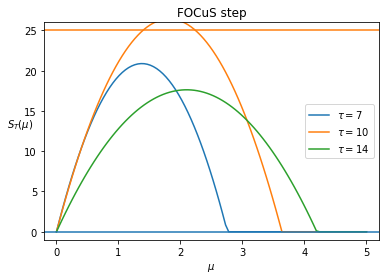

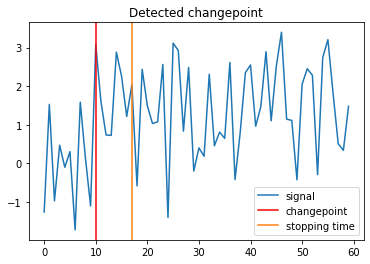

In [12]:
np.random.seed(30)
threshold=25
X = np.concatenate((np.random.normal(size=10), np.random.normal(size=50) + 1.5))
significance, changepoint, stopping_time = focus(X, threshold=threshold, plot=True) #if you change plot to False it goes a lot faster

plt.plot(X)
plt.title("Detected changepoint")
if changepoint is not None:
    plt.axvline(changepoint, color='red')
    plt.axvline(stopping_time, color='C1')
    plt.legend(['signal','changepoint', 'stopping time'])

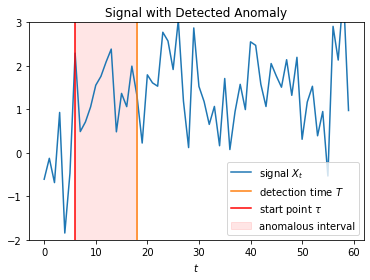

In [10]:
plt.plot(X, label="signal $X_t$")
plt.title("Signal with Detected Anomaly")
plt.xlabel("$t$")
if changepoint is not None:
    plt.fill((changepoint, stopping_time, stopping_time, changepoint), (-5, -5, 15, 15), color="red", alpha=0.1, label="anomalous interval") 
    plt.axvline(stopping_time, color='C1', label="detection time $T$")
    plt.axvline(changepoint, color='red', label="start point $\\tau$")
    plt.ylim(-2, 3)
    
    plt.legend()

## Improvements

There are obviously a lot of computational speedups that can be done on this code. Among them are:
* All the generic stuff about Python being slow and this code doing more things than it needs to.
* Python's list objects are quite slow to access and this algorithm doesn't require random access (only compares neighbours), so a C-style list object would be better.
* Most of the divisions in the algorithm can be eliminated as they take place within the context of comparisons, and comparing a==bc is faster than comparing a/b==c

### Some more mathsy areas of investigation:
* As the quadratics undergo linear updates, the differences between neighbouring quadratics remain unchanged with a global update. That means you technically don't need to update each quadratic in order to do pruning checks.
* It's possible to get an overestimate of the global max by using the sum of max differences between neighbouring quadratics, meaning we don't need to iterate at all through the quadratic list until this overestimate hits our threshold.

These two things mean it should be possible to design FOCuS to operate with a computational time at each timestep independent of the number of quadratics because it only iterates through quadratics it is pruning, so the algorithm would be *truly* linear-time in computational speed (though not technically in memory), and a very fast linear time at that (on average adding/pruning one quadratic per step).

* Also: by setting a nonzero lower bound on the values of $\mu$ under consideration for changes (equivalent to setting a maximum time interval), we can get stronger theoretical bounds on the number of quadratics the algorithm collects as it goes through a signal.

This final one *would* render a version of FOCuS completely linear time in both computational speed and memory. FOCuS's memory requirements are very small even without this though.


In [10]:
stopping_time

70